#### Calculate mutual information

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas
from scipy.linalg import det
from shapely.geometry import Point, Polygon
import pandas as pd
import math
import json
from scipy.spatial import Delaunay
from generate_sample_U import *
import dill as pickle


In [2]:
def load_model(filename):
    path = f"../gp-models/GPR-models/ST-SVGP/{filename}/{filename}"
    model = pickle.load(open(f"{path}_model.sav", 'rb'))
    df = pickle.load(open(f"{path}_df.sav", 'rb'))
    train_df = pickle.load(open(f"{path}_train_df.sav", 'rb'))
    test_df = pickle.load(open(f"{path}_test_df.sav", 'rb'))
    scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))
    
    return model, df, train_df, test_df, scalers

In [3]:
# incrementally grab the sensors in the order that they are placed
# (calculate MI for 1st sensor, then for 1st & 2nd sensor, etc.)
# initialize list for MI storage
def GPR_mutual_info(GPR, k, A_df, U_df, t):
    MI = np.array([],dtype=float)

    for i in range(k):
        print(i)
        A_df["t"] = t
        A = A_df[["t", "scaled_latitude", "scaled_longitude"]].values
        U_df["t"] = t
        U = U_df[["t", "scaled_latitude", "scaled_longitude"]].values
        
        n = np.arange(0,i+1)
        ## grab first n sensors placed
        test_X = A[n,:].reshape(i+1, A.shape[1])        
        
        ## add in U
        test_XU = np.append(test_X, U, axis=0)

        ## compute covariance matrix
        if not isinstance(test_XU, np.ndarray):
            test_XU = np.array(test_XU).reshape(-1,1)
        cov_mat_XU = GPR.predict(test_XU, return_cov=True)[1]

        print(cov_mat_XU)
        print(cov_mat_XU.shape)
        
        XX_cov = cov_mat_XU[:i+1,:i+1]
        #print(XX_cov.shape)
        UU_cov = cov_mat_XU[i+1:cov_mat_XU.shape[0], i+1:cov_mat_XU.shape[0]]
        #print(UU_cov.shape)
        
        ## calculate 
        det_XU = det(cov_mat_XU)
        det_XX = det(XX_cov)
        det_UU = det(UU_cov)

        print("det_XU = " + str(det_XU))
        print("log(det_XU) = " + str(np.log(det_XU)))
        print("det_XX = " + str(det_XX))
        print("log(det_XX) = " + str(np.log(det_XX)))
        print("det_UU = " + str(det_UU))
        print("log(det_UU) = " + str(np.log(det_UU)))
        if det_XU == 0:
            print("skipping " + str(i))
        else:
            mi_star = 0.5*np.log((det_XX * det_UU) / (det_XU))
            alt_mi_star = 0.5*(np.log(det_XX) + np.log(det_UU) - np.log (det_XU))
            print("mi = " + str(mi_star))
            print("alternative mi = " + str(alt_mi_star))
            MI = np.append(MI, mi_star)

    return MI

In [4]:
def STVGP_mutual_info(GP, k, A_df, U_df, t, verbose=1):
    '''
    GP : ST-VGP model
    k : int : number of sensors to be placed
    A_df : pd.DataFrame : sensor sites of optimal mutual information; columns = ["t", "latitude", "longitude", "scaled_latitude", "scaled_longitude"]
    U_df : pd.DataFrame : locations where sensors cannot be placed
    t : int : time index
    '''
    MI = np.array([],dtype=float)

    for i in range(k):
        A_df["t"] = t
        A = A_df[["scaled_latitude", "scaled_longitude"]].values
        U_df["t"] = t
        U = U_df[["scaled_latitude", "scaled_longitude"]].values

        
        ## grab first n sensors placed
        n = np.arange(0,i+1)
        test_X = A[n,:].reshape(i+1, A.shape[1])

        ## add in U
        yA_R = np.append(test_X, U, axis=0)

        yA_t = np.array([[t]])
        yA_R = np.tile(yA_R, [yA_t.shape[0], 1, 1])
        yA_mean, cov_mat_XU = GP.likelihood_cov(X=yA_t, R=yA_R)

        if verbose:
            print(cov_mat_XU)
            print(cov_mat_XU.shape)
        
        XX_cov = cov_mat_XU[:i+1,:i+1]
        #print(XX_cov.shape)
        UU_cov = cov_mat_XU[i+1:cov_mat_XU.shape[0], i+1:cov_mat_XU.shape[0]]
        #print(UU_cov.shape)
        
        ## calculate 
        det_XU = det(cov_mat_XU)
        det_XX = det(XX_cov)
        det_UU = det(UU_cov)

        if verbose: 
            print("det_XU = " + str(det_XU))
            print("log(det_XU) = " + str(np.log(det_XU)))
            print("det_XX = " + str(det_XX))
            print("log(det_XX) = " + str(np.log(det_XX)))
            print("det_UU = " + str(det_UU))
            print("log(det_UU) = " + str(np.log(det_UU)))
        if det_XU == 0:
            print("skipping " + str(i))
        else:
            mi_star = 0.5*np.log((det_XX * det_UU) / (det_XU))
            # alt_mi_star = 0.5*(np.log(det_XX) + np.log(det_UU) - np.log (det_XU))
            print(f"mi ({i+1})= {mi_star}")
            # print("alternative mi = " + str(alt_mi_star))
            MI = np.append(MI, mi_star)
            
    return MI

In [5]:
model_name = 'STSVGP_MODEL_3207'
model, df, train_df, test_df, scalers = load_model(model_name)

# path = f"../gp-models/GPR-models/ST-SVGP/{model_name}/{model_name}"
# model = pickle.load(open(f"{path}_model.sav", 'rb'))
# scalers = pickle.load(open(f"{path}_scalers.sav", 'rb'))

In [6]:
A_df = pickle.load(open(f'../optimization/krause-output/{model_name}_mutual_info_k_100_likelihood_df.sav', 'rb'))
# scale coordinates
k = A_df.shape[0]
for feature in scalers:
    A_df[f"scaled_{feature}"] = scalers[feature].transform(A_df[[feature]].values)#+0.00001*np.random.rand(k, 1)
A_df

FileNotFoundError: [Errno 2] No such file or directory: '../optimization/krause-output/STSVGP_MODEL_3207_mutual_info_k_100_likelihood_df.sav'

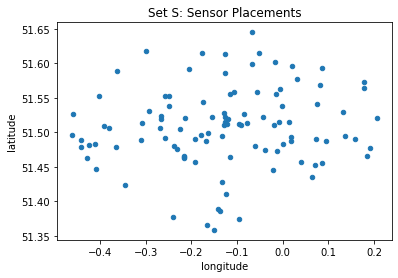

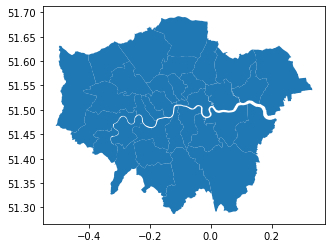

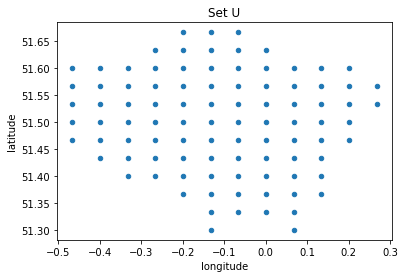

In [7]:
S_df, U_df = generate_placement_sets(df, scalers, n=1000, plot=True)

In [8]:
t = 0

In [9]:
MI = STVGP_mutual_info(model, k, A_df, U_df, t, verbose=0)
MI

mi (1)= 0.19458150759544435
mi (2)= 0.40084208991848824
mi (3)= 0.5814094725184273
mi (4)= 0.8102561269703357
mi (5)= 0.9610950700952268
mi (6)= 1.1406579472167495
mi (7)= 1.3275201120910103
mi (8)= 1.5228693170510599
mi (9)= 1.842471691181264
mi (10)= 2.043360226022106
mi (11)= 2.3391379275819077
mi (12)= 2.5554854220903382
mi (13)= 2.8073021863283993
mi (14)= 3.0301157697916277
mi (15)= 3.2465248823938744
mi (16)= 3.3603557417288354
mi (17)= 3.564450763119529
mi (18)= 3.623011528962924
mi (19)= 3.8196546750227265
mi (20)= 3.850745215965245
mi (21)= 3.9436129338947743
mi (22)= 4.065596898030339
mi (23)= 4.1809405287067705
mi (24)= 4.215274105491147
mi (25)= 4.265681671099951
mi (26)= 4.329586804852282
mi (27)= 4.3822018400788
mi (28)= 4.477187392949234
mi (29)= 4.511920776246438
mi (30)= 4.549837290201094
mi (31)= 4.611444538577998
mi (32)= 4.648328600556831
mi (33)= 4.806619341198191
mi (34)= 4.93328947077017
mi (35)= 4.999555932844432
mi (36)= 5.074459688012837
mi (37)= 5.1137063497

array([0.19458151, 0.40084209, 0.58140947, 0.81025613, 0.96109507,
       1.14065795, 1.32752011, 1.52286932, 1.84247169, 2.04336023,
       2.33913793, 2.55548542, 2.80730219, 3.03011577, 3.24652488,
       3.36035574, 3.56445076, 3.62301153, 3.81965468, 3.85074522,
       3.94361293, 4.0655969 , 4.18094053, 4.21527411, 4.26568167,
       4.3295868 , 4.38220184, 4.47718739, 4.51192078, 4.54983729,
       4.61144454, 4.6483286 , 4.80661934, 4.93328947, 4.99955593,
       5.07445969, 5.11370635, 5.17635612, 5.29318561, 5.30103452,
       5.34114829, 5.38078186, 5.41499992, 5.46702655, 5.52008823,
       5.5405689 , 5.61148991, 5.71082309, 5.754185  , 5.78162727,
       5.80366221, 5.8278506 , 5.83954034, 5.84876516, 5.94494099,
       5.96370523, 6.00295659, 6.10758726, 6.18278841, 6.2294453 ,
       6.29082622, 6.36305916, 6.40550003, 6.43485038, 6.46938422,
       6.47914645, 6.48903141, 6.53217648, 6.54336819, 6.5631542 ,
       6.57069826, 6.59546252, 6.64381902, 6.65028497, 6.65849

Text(0.5, 0, 'Number of Sensors')

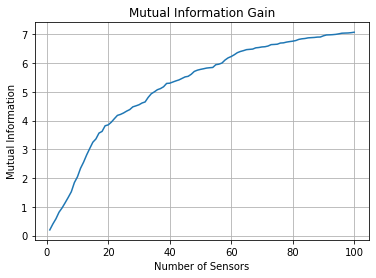

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# MI_placeholder = [np.log(i) for i in range(k)]
# plt.plot(list(range(k)), MI_placeholder)

plt.plot(list(range(1, k+1)), MI)
plt.grid()
plt.title('Mutual Information Gain')
plt.ylabel('Mutual Information')
plt.xlabel('Number of Sensors')